### Tutorial 3 - Cross-Parliament Comparison 

In **Tutorial 2**, we used descriptive statistics and visualizations to explore the topical and sentimental landscapes of individual parliaments. We asked *what* topics are discussed, *how* they are discussed and identified some interesting patterns, such as the coalition-opposition sentiment divide. These findings however, were largely qualitative and country-specific.

This tutorial brings our analysis on another level into the area of **quantitative comparison and clustering**, which represent core tasks in **Computational Lingusitics** and **NLP** (Natural Language Processing). We move from asking *"what is the pattern in country X?"* to a more systematic, data-driven question: *"How similar or different are these parliamentary discourses from one another?"*

To answer this, we introduce a fundamental NLP method for comparing distributions: **cosine distance in a vector space model**. In this framework, each country is represented as a high-dimensional cector where:
- Each dimension corresponds to a **CAP category** (for topical analysis)
- The value in each dimension can be the **total word count** (to model topic prevalence) or the **average sentimnet** (to model emotional tone).

By measuring the cosine distance of the angle between these country-vectors, we can quantify their similarity in discourse profile, independent of the amount of text that was produced. This allows us to:
- **Cluster** parliaments into groups with similar discoursive focus or emotional tone. 
- **Identify nearest neighbors** to find which countries have the most similar parliamentary cultures.


**Possible research questions:**
- *Which countries have the most similar sentiment patterns across CAP categories?*
- *How similar are countries in their topic distributions based on word counts?*
- *For a specific CAP category, which countries exhibit the most similar sentiment patterns?*

This tutorial includes:
- **Introduction to Cosine Distance** 
- **Load, read and filter the Data**
- **Compute cosine distance between countries based on sentiment**
    1. Example: Serbia (RS) & Croatia (HR)
    2. All countries combined
    3. The 3 nearest neighbors
- **Compute cosine distance between CAP category distributions (based on word counts)**
    1. Example: Serbia (RS) & Croatia (HR)
    2. All countries combined
    3. The 3 nearest neighbors

#### **1. Introduction to Cosine Distance**
**Cosine Distance** is way of comparing **patterns** between countries, regardless of size. Instead of asking *"which country's parliament has more speeches?"*, it asks *"how similar are their profiles across topics or sentiments?"*.

We turn each country's CAP-category-distribution or CAP x sentiment score - values into a vector and then compare the *angle* between those vectors. 
- If two countries talk about the same topics in similar proportions (or show similar sentiment patterns), their cosine distance is **small** (close together).
- If their focus is very different, the distance is **large** (far apart).

This method lets us:
- Cluster countries into groups with similar discourse (via dendrograms)
- Identify each parliament's "nearest neighbor"
- Compare similarity across all MPs, coalitions or oppositions
- Zoom into specific topics (e.g. *Environment*) to see which countries align or diverge

#### **Example - How Cosine Distance Works**
We look at two countries (A and B) and we want to find out how similar they are in how mcuh they talk about 3 topics: *Education, Health, Environment*.

| Country | Education | Health | Environment |
|---------|--------|--------|-------------|
| A       | 50     | 30     | 20          |
| B       | 100    | 60     | 40          |

--> If we just compared **word counts**, Country B seems like people there talk more about each topic - but that doesn't tell us how **similar** the countries are.

So, we convert them into proportions (distributions):

| Country | Economy | Health | Environment |
|---------|--------|--------|-------------|
| A       | 0.50     | 0.30     | 0.20          |
| B       | 0.50    | 0.30     | 0.20          |

Now, the vectors are:
- A = [0.5, 0.3, 0.2]
- B = [0.5, 0.3, 0.2]

**Cosine Similarity compares the *angle* between vectors**:
$$
\text{cosine\ similarity}(A, B) = \frac{A \cdot B}{\|A\| \cdot \|B\|}
$$
- If the vectors point in the **same direction** --> similarity = 1 (distance = 0)
- If they are **orthogonal (completely different)** ---> similarity = 0 (distance = 1)

Here: 
- Countries A and B have identical proportions, so cosine similarity = 1
- They are perfectly similar in terms of *distribution across topics*, even though B has more total speeches


**2. Setup & Data Loading**

This setup (installing/importing) libraries and data loading & filtering steps are the **same as in Tutorial 1**. For detailed explanations, see **Tutorial 1, Sections 1-2**.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
import csv
from pathlib import Path
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
# Set consistent style
sns.set_theme(style="whitegrid", font_scale=1.2)

In [3]:
# ---- 1. First, we have to increase the CSV field size limit ----
max_int = 2**31 - 1
while True:
    try:
        csv.field_size_limit(max_int)
        break
    except OverflowError:
        max_int = max_int // 10

countries = [
    "AT",
    "BA",
    "BE",
    "BG",
    "CZ",
    "DK",
    "EE",
    "ES",
    "ES-CT",
    "ES-GA",
    "ES-PV",
    "FR",
    "GB",
    "GR",
    "HR",
    "HU",
    "IS",
    "IT",
    "LV",
    "NL",
    "NO",
    "PL",
    "PT",
    "RS",
    "SE",
    "SI",
    "TR",
    "UA",
]  # change country codes according to your available datasets

base_dir = Path("../speeches_no_text").resolve()

# ---- 2. Choose what columns to read (including CAP and sentiment columns) ----
cols_to_keep = [
    "id",
    "date",
    "lang_code",
    "lang",
    "speaker_role",
    "speaker_MP",
    "speaker_minister",
    "speaker_party",
    "speaker_party_name",
    "party_status",
    "party_orientation",
    "speaker_id",
    "speaker_name",
    "speaker_gender",
    "speaker_birth",
    "word_count",
    "CAP_category",
    "sent3_category",
    "sent6_category",
    "sent_logit",
]

# ---- 3. Define dtypes to reduce memory ----
dtypes = {
    "id": str,
    "date": str,
    "lang_code": "category",
    "lang": "category",
    "speaker_role": "category",
    "speaker_MP": "category",
    "speaker_minister": "category",
    "speaker_party": "category",
    "speaker_party_name": "category",
    "party_status": "category",
    "party_orientation": "category",
    "speaker_id": "category",
    "speaker_name": "category",
    "speaker_gender": "category",
    "speaker_birth": "Int32",
    "word_count": "Int32",
    "CAP_category": "category",
    "sent3_category": "category",
    "sent6_category": "category",
    "sent_logit": "float32",
}

# ---- 4. Create lists to accumulate filtered chunks ----
all_chunks = []

for country in countries:
    file_path = base_dir / f"cda1055_dat_ParlaCAP-{country}_speeches_no_text.tsv.zip"

    # --- 4.1. Read in chunks using pandas.read_csv ----
    for chunk in pd.read_csv(
        file_path,
        sep="\t",
        usecols=cols_to_keep,
        dtype=dtypes,
        chunksize=50_000,
        engine="python",
        na_values=["-"],
        keep_default_na=False,
    ):
        chunk["country"] = country
        chunk["country"] = chunk["country"].astype("category")

        # ---- 4.2. Filter MPs with regular role ----
        filtered_chunk = chunk.query("speaker_MP == 'MP' and speaker_role == 'Regular'")

        # ---- 4.3. Drop rows where CAP_category or sentiment is empty ----
        filtered_chunk = filtered_chunk[
            filtered_chunk["CAP_category"].notna()
            & (filtered_chunk["CAP_category"] != "")
            & filtered_chunk["sent3_category"].notna()
            & (filtered_chunk["sent3_category"] != "")
            & filtered_chunk["sent6_category"].notna()
            & (filtered_chunk["sent6_category"] != "")
        ]

        # ---- 4.4. Accumulate filtered chunks ----
        if not filtered_chunk.empty:
            all_chunks.append(filtered_chunk)

# ---- 5. Concatenate all accumulated chunks into DataFrames ----
filtered_all = pd.concat(all_chunks, ignore_index=True)
del all_chunks
print("All filtered:", filtered_all.shape)

All filtered: (4225608, 21)


In [4]:
filtered_all = filtered_all[~filtered_all["CAP_category"].isin(["Mix", "Other"])]
filtered_all["CAP_category"] = filtered_all["CAP_category"].astype("category")
filtered_all["CAP_category"] = filtered_all[
    "CAP_category"
].cat.remove_unused_categories()


**3. Cosine Distance Analysis of Sentiment**

**3.1. Example: Serbia (RS) & Croatia (HR)**

In this first step of our cosine distance analysis, we will explore how similar or different two selected countries are in terms of the sentiment expressed across policy domains. We begin with a **pairwise comparison** between **Serbia (RS)** and **Croatia (HR)**. These two parliaments are chosen because as neighboring countries with a shared yet often contrasting political and historical trajectory, they are an interesting first case study for our cosine distance analysis. 

To do this, the code below constructs a **country-by-category sentiment matrix**, where each cell represents the average sentiment expressed in speeches for a given CAP category. With the help of this matrix, the **cosine distance** between RS and HR is computed. As a result, we get a single similarity score that represents how closely their sentiment profiles match. 

This serves as a numerical view of these relationships, rounded to three decimal places for clarity. 

In addition to the numeric score, we also visualize the results with a **heatmap**. The heatmap displays the average sentiment values of RS and HR side by side across all CAP categories, with **red indicating lower sentimnet values and green indicating higher ones**. This makes it easy to spot where the two countries align more closely and where they differ.

Cosine distance between RS and HR: 0.003


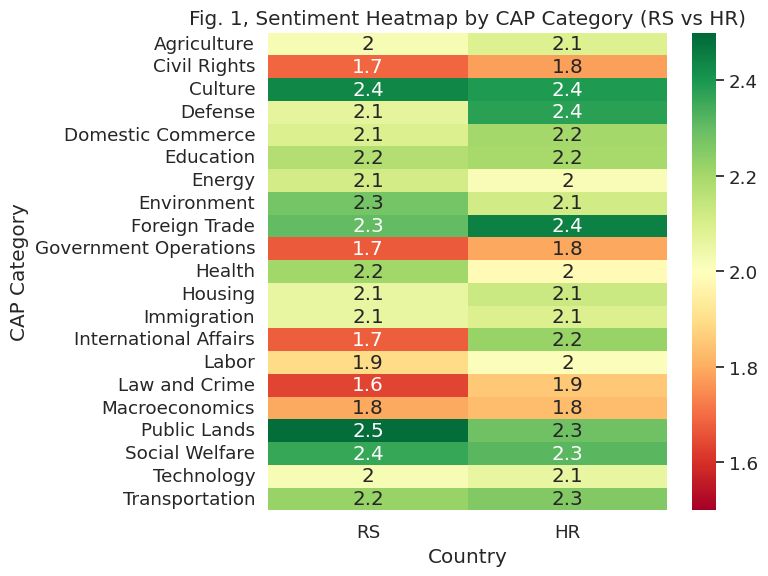

In [5]:
# ---- 1. Pivot data: rows = country, columns = CAP_category, values = mean sentiment ----
# You can change which countries to include by modifying the filtered DataFrame before pivoting,
# or by selecting specific country rows after pivoting.
country_cap_sent = (
    filtered_all.groupby(["country", "CAP_category"], observed=True)["sent_logit"]
    .mean()
    .unstack(fill_value=0)
)

# ---- 2. Compute cosine distance between RS and HR ----
# To compare different countries, replace "RS" and "HR" with the desired country codes
cosine_val = cosine_distances(
    [country_cap_sent.loc["RS"].values], [country_cap_sent.loc["HR"].values]
)[0][0]

# ---- 3. Print the result (rounded to 3 decimals) ----
print(f"Cosine distance between RS and HR: {cosine_val:.3f}")

# ---- 4. Prepare data for heatmap: CAP categories (rows), countries (columns) ----
# Here, you can include any list of countries to compare by changing the list ["RS", "HR"]
pair_sent = country_cap_sent.loc[["RS", "HR"]].T

# ---- 5. Plot heatmap of RS vs HR mean sentiment by CAP category ----
plt.figure(figsize=(8, 6))
sns.heatmap(pair_sent, annot=True, cmap="RdYlGn", vmin=1.5, vmax=2.5, cbar=True)
plt.title("Fig. 1, Sentiment Heatmap by CAP Category (RS vs HR)")
plt.ylabel("CAP Category")
plt.xlabel("Country")
plt.tight_layout()
plt.show()


*The pairwise cosine distance between **Serbia** and **Croatia** is very small at **0.003**. This indicates that their overall sentiment profiles across CAP categories are **highly similar**. Essentially, on most topics, parliamentary speeches in these two neighboring countries share a similar emotional tone.*

*Looking more closely at individual CAP categories on the heatmap, we can further identify a few differences:*
+ **International Affairs**: *RS has an average sentiment of **1.7**, while HR scores **2.2**, indicating that Croatia's speeches are more positive or optimistic in this domain compared to Serbia*. 
+ **Law and Crime**: *RS scores **1.6**, slightly lower than HR's **1.9**, suggesting a small divergence in sentiment around legal and criminal policy discussions.*

*For all other CAP categories, the sentiment scores are nearly identical which again underlines the overall closeness of the two countries' sentiment profiles and emotional tones, captured by the cosine distance.* 

*This pairwise comparison serves as a benchmark for interpreting larger-scale patterns when we extend the analysis to **all countries** of ParlaMint.*

**3.2. Cosine distance analysis of sentiment - all countries**

In the following step, we will extend the same procedure to **all countries in the dataset**.

The first step is again to compute the **full cosine distance matrix** which consists of the similarity values between every pair of countries based on their average sentiment across CAP categories. Each entry in this matrix represents the cosine distance between two countries' sentiment profiles. This provides a numerical measure of how closely their parliamentary rhetoric aligns. Additionally, the full cosine distance matrix can be **exported as a TSV file** for further analysis or sharing of the results.

To make these relationships easier to interpret, we visualize the matrix as a **heatmap**. The heatmaps provides a quick overview of which countries have similar sentiment patterns (green) and which differ more strongly (red). 

Finally, we use **hierarchical clustering** to generate a **dendrogram**. This visualization method groups countries based on the similarity of their sentiment profiles, revealing clusters of parliaments that share comparable emotional tones. The dendrogram does not only summarize the pairwise relationships captured in the heatmap but also helps identify regional or political patterns that might not be immediately obvious otherwise. 

country       AT       BA       BE       BG       CZ       DK       EE  \
country                                                                  
AT       0.00000  0.00319  0.00121  0.00198  0.00135  0.00152  0.00138   
BA       0.00319  0.00000  0.00242  0.00286  0.00224  0.00203  0.00133   
BE       0.00121  0.00242  0.00000  0.00157  0.00104  0.00175  0.00063   
BG       0.00198  0.00286  0.00157  0.00000  0.00161  0.00232  0.00135   
CZ       0.00135  0.00224  0.00104  0.00161  0.00000  0.00177  0.00055   
DK       0.00152  0.00203  0.00175  0.00232  0.00177  0.00000  0.00127   
EE       0.00138  0.00133  0.00063  0.00135  0.00055  0.00127  0.00000   
ES       0.00182  0.00344  0.00251  0.00263  0.00193  0.00233  0.00169   
ES-CT    0.00253  0.00389  0.00342  0.00289  0.00213  0.00256  0.00247   
ES-GA    0.00768  0.00868  0.00746  0.00966  0.00768  0.00959  0.00707   
ES-PV    0.00352  0.00358  0.00260  0.00231  0.00401  0.00375  0.00308   
FR       0.00233  0.00226  0.00217  0.

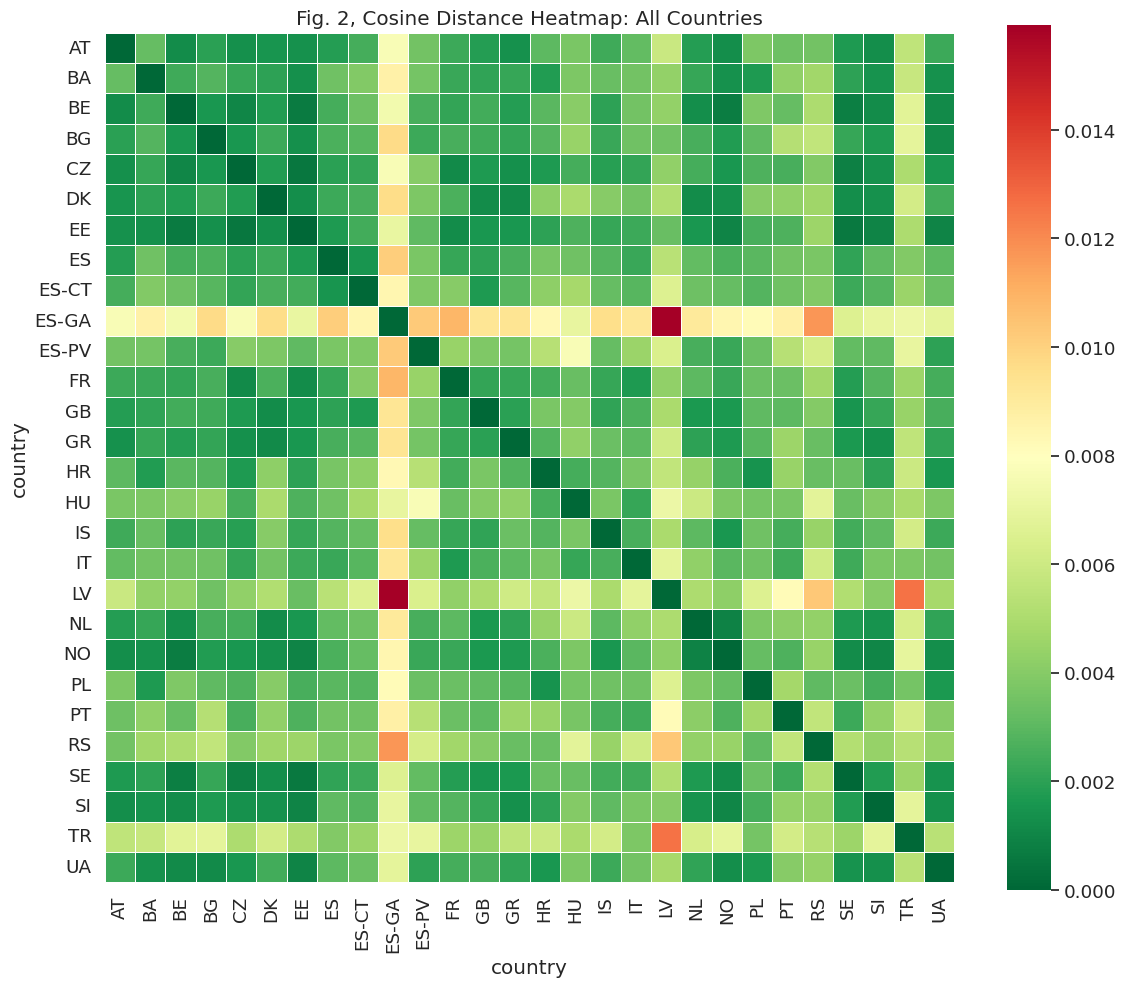

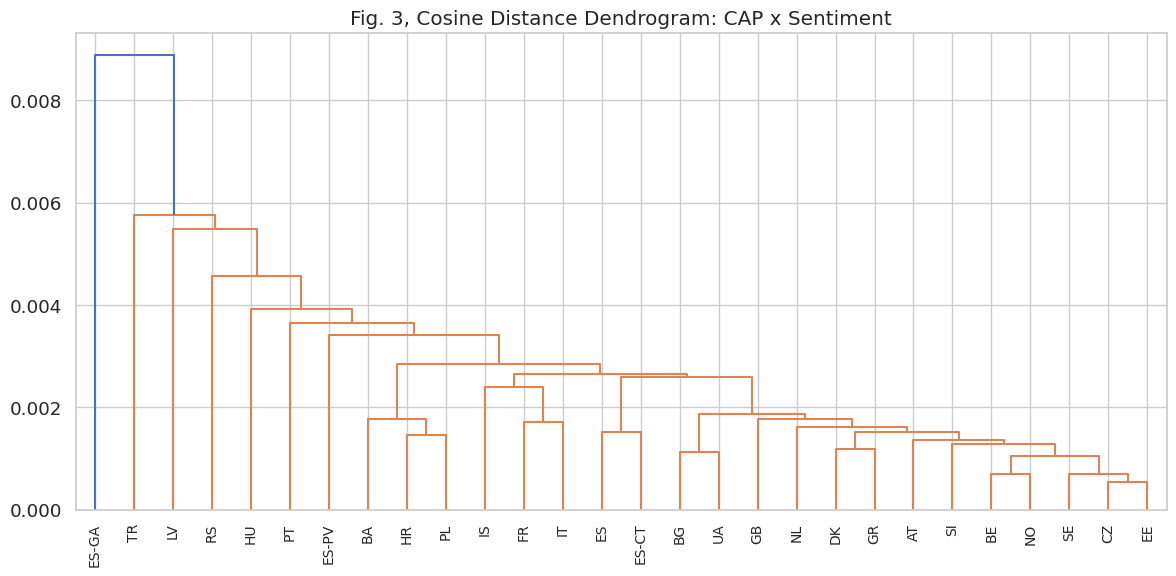

In [6]:
# ---- 1. Pivot data: rows = country, columns = CAP_category, values = mean sentiment ----
country_cap_sent = (
    filtered_all.groupby(["country", "CAP_category"], observed=True)["sent_logit"]
    .mean()
    .unstack(fill_value=0)
)

# ---- 2. Compute cosine distance between all countries ----
cosine_matrix = cosine_distances(country_cap_sent.values)

# ---- 2.1. Convert to readable DataFrame ----
cosine_df = pd.DataFrame(
    cosine_matrix, index=country_cap_sent.index, columns=country_cap_sent.index
)

# ---- 2.2. Round to 5 decimals and print ----
cosine_df = cosine_df.round(5)
print(cosine_df)

# ---- 2.3. Export cosine distance matrix to TSV ----
cosine_df.to_csv("cosine_distance_matrix.tsv", sep="\t")

# ---- 3. Heatmap of the full cosine distance matrix ----
plt.figure(figsize=(12, 10))
sns.heatmap(
    cosine_df,
    annot=False,
    cmap="RdYlGn_r",  # reversed red-green: red = high distance, green = low distance
    linewidths=0.5,
    square=True,
)
plt.title("Fig. 2, Cosine Distance Heatmap: All Countries")
plt.tight_layout()
plt.show()

# ---- 4. Convert to condensed matrix for hierarchical clustering ----
condensed = squareform(cosine_matrix, checks=False)

# ---- 5. Plot dendrogram ----
linked = linkage(condensed, method="average")

plt.figure(figsize=(12, 6))
dendrogram(linked, labels=country_cap_sent.index.tolist(), leaf_rotation=90)
plt.title("Fig. 3, Cosine Distance Dendrogram: CAP x Sentiment")
plt.tight_layout()
plt.show()

*From Figure 2, the **heatmap of the full cosine distance matrix**, several patterns become apparent. First, we have a few countries that are **highly divergent** (Spain (ES), Gallicia (ES-GA), Latvia (LV)), which means that they stand out as very different from most other countries, indicating that their parliamentary sentiment patterins across CAP categories are more unique compared to the majority.*

*Second, we can see some **specific outlier pairs**. Some countries differ strongly from each other, such as LV & ES-GA, LV & Turkey (TR) or RS & LV, highlighting notable differences in how these parliaments frame policy topics.*

*Lastly, we also can identify some **highly similar countries**. Belgium (BE) & Austria (AT), Sweden (SE) & Belgium (BE), SE & Czech Republic (CZ) and SE & Estonia (EE) all show very similar sentiment profiles.*

*Figure 3, the **dendrogram**, visualizes this too and offers a hierarchical view of country similarities: clusters forming at low linkage distances indicate **high similarity** (e.g. BE, SE, VZ, EE), while countries that branch of early or are linked with a differently coloured line, like ES-GA and LV, are **more distinct**, confirming their outlier status. It also reveals sub-clusters that may reflect regional, political or historical patterns that are not immediately recognizable in the heatmap.*

**3.3. Find the nearest neighbors (3 most similar countries)**

Following the heatmap and dendrogram analysis, we now turn to a **more concrete, country-specific view**.The code below uses cosine distance to find the **nearest neighbors** for each country - that is, the three countries whose sentiment profiles are most similar based on the cosine distance. 

This approach is a way to see which parliaments are **most closely aligned** in their emotional tone across CAP categories. For each country, we mask the diagonal of the cosine distance matrix (to avoid self-comparison) and select the three smallest distances - the nearest neighbors.

In [7]:
# ----- 1. Find the 3 most similar countries ----
masked_dist_df = cosine_df.mask(np.eye(len(cosine_df), dtype=bool))
nearest_neighbors = masked_dist_df.apply(
    lambda row: row.nsmallest(3).index.tolist(), axis=1
)

# ---- 2. Display the results ----
for country, neighbors in nearest_neighbors.items():
    print(f"{country}: {', '.join(neighbors)}")

AT: BE, NO, SI
BA: EE, UA, NO
BE: EE, NO, SE
BG: UA, EE, BE
CZ: EE, SE, BE
DK: GR, GB, NL
EE: CZ, SE, BE
ES: ES-CT, EE, AT
ES-CT: ES, GB, CZ
ES-GA: SE, UA, SI
ES-PV: UA, NO, BG
FR: CZ, EE, IT
GB: DK, SE, EE
GR: DK, CZ, SI
HR: PL, UA, CZ
HU: IT, HR, CZ
IS: NO, CZ, BE
IT: FR, CZ, HU
LV: EE, BG, SI
NL: NO, DK, BE
NO: BE, NL, EE
PL: HR, UA, BA
PT: SE, IT, IS
RS: PL, GR, HR
SE: EE, BE, CZ
SI: EE, NO, BE
TR: PL, IT, ES
UA: EE, BG, BE


*This table of nearest neighbors shows, for each country, the **three parliaments whose sentiment profiles are most similar** across CAP categories. For example, **Austria (AT)** is most similar to **Belgium (BE), Estonia (EE) and Greece (GR)**. **Serbia (RS)** on the other hand aligns closely with **Poland (PL), Greece (GR) and Croatia (HR)**.*

Overall, the results reveal patterns of similarity and divergence in parliamentary rhetoric that can reflect **regional proximity, shared political traditions or comparable policy approaches**.

**4. Cosine Distance Analysis of Topic Distributions (Word Count)**

In this section, we move from **sentiment** to **topic prevalence**. Similar to **Tutorial 2, Section 3.4.**. we will explore now how parliaments allocate their relative attention to different CAP categories. Instead of asking *how positively or negatively* countries discuss topics, we now ask *how similarly do they devote their time to different topics*. This method allows us to identify countries with **similar topical priorities**, outliers that focus on very different topics and clusters of countries with comparable parliamentary attention patterns.

**4.1. Example: Serbia (RS) & Croatia (HR)**

We start with a **pairwise comparison** between RS and HR, similar to what we did in **Section 3.1** for sentiment. 

First, we will construct a country-by-CAP-category **word count matrix** for RS and HR. Then, we compute the **cosine distance** between their topic distributions and visualize our results using a **heatmap** to see where the countries align or differ.

Cosine distance (topic distribution) between RS and HR: 0.028


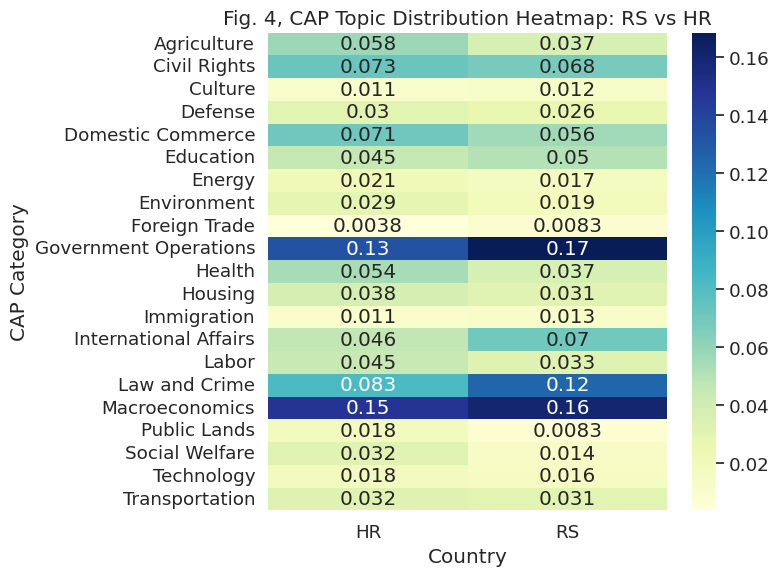

In [8]:
# ---- 1. Pivot data: rows = country, columns = CAP_category, values = total word count ----
# You can change which countries to include by modifying the list in `isin([...])`
pair_words = (
    filtered_all[filtered_all["country"].isin(["RS", "HR"])]
    .groupby(["country", "CAP_category"], observed=True)["word_count"]
    .sum()
    .unstack(fill_value=0)
)

# Convert to float to avoid dtype object issues
pair_words = pair_words.astype(float)

# ---- 1.1 Optional: normalize to proportions ----
# This step is useful to compare countries regardless of their total speech volume
pair_words_norm = pair_words.div(pair_words.sum(axis=1), axis=0)

# ---- 2. Compute cosine distance between RS and HR ----
# To compare different countries, replace "RS" and "HR" with desired country codes
cosine_val_pair = cosine_distances(
    [pair_words_norm.loc["RS"].values], [pair_words_norm.loc["HR"].values]
)[0][0]
print(f"Cosine distance (topic distribution) between RS and HR: {cosine_val_pair:.3f}")

# ---- 3. Heatmap ----
# You can include more than two countries by selecting multiple rows in pair_words_norm.loc[...]
plt.figure(figsize=(8, 6))
sns.heatmap(pair_words_norm.T, annot=True, cmap="YlGnBu", cbar=True)
plt.title("Fig. 4, CAP Topic Distribution Heatmap: RS vs HR")
plt.ylabel("CAP Category")
plt.xlabel("Country")
plt.tight_layout()
plt.show()


*The cosine distance between RS and HR based on topic distributions (word counts) is **0.028**. This is slightly higher than the distance we observed for sentiment but still indicates that their overall topic focus is fairly similar.*

*The heatmap further visualizes how much attention each parliament devotes to the different CAP topics. Some topics have very small shares - for example, **Foreign Trade** accounts for only 0.38% of HR's total speech (0.0038), indicating it is rarely discussed. The largest shares are **Government Operations** and **Macroeconomics**, consistent with what we observed in **Tutorial 2**. RS allocates roughly 17% of all speech to Government Operations, which is noticeably higher than HR and could suggest a stronger focus on administrative matters in the parliament. Another notable difference is **Law and Crime**, where RS dedicates 12% of speech compared to HR's 3,8%.*

*These differences highlight areas where parliamentary attention diverges and could be further explored in comparative studies.*

**4.2. Cosine distance analysis of topic distribution - all countries**

Next, we extend the analysis to **all countries** to examine **broader patterns of topical similarity**.

For that matter, we first build a **country-by-CAP-category word count matrix** for all countries where we normalize the proportions to compare the relative topic emphasis. Then, we compute the **cosine distance** for all country pairs. The output cosine distance matrix can be exported to **TSV** for further analysis. In the end, we visualize the results using a **heatmap** and a **dendrogramm** to identify clusters and outliers.

country       AT       BA       BE       BG       CZ       DK       EE  \
country                                                                  
AT       0.00000  0.26429  0.15164  0.07536  0.05366  0.11068  0.03203   
BA       0.26429  0.00000  0.39477  0.22355  0.22088  0.43880  0.21140   
BE       0.15164  0.39477  0.00000  0.12772  0.16786  0.13399  0.18715   
BG       0.07536  0.22355  0.12772  0.00000  0.03867  0.18437  0.05821   
CZ       0.05366  0.22088  0.16786  0.03867  0.00000  0.17323  0.03095   
DK       0.11068  0.43880  0.13399  0.18437  0.17323  0.00000  0.13547   
EE       0.03203  0.21140  0.18715  0.05821  0.03095  0.13547  0.00000   
ES       0.07336  0.25600  0.17676  0.14625  0.11701  0.19895  0.10760   
ES-CT    0.14259  0.27433  0.29940  0.18152  0.14848  0.22934  0.12426   
ES-GA    0.13013  0.45033  0.24485  0.14848  0.10566  0.21891  0.12866   
ES-PV    0.06902  0.35464  0.18149  0.12052  0.10037  0.14741  0.10103   
FR       0.07606  0.32036  0.11018  0.

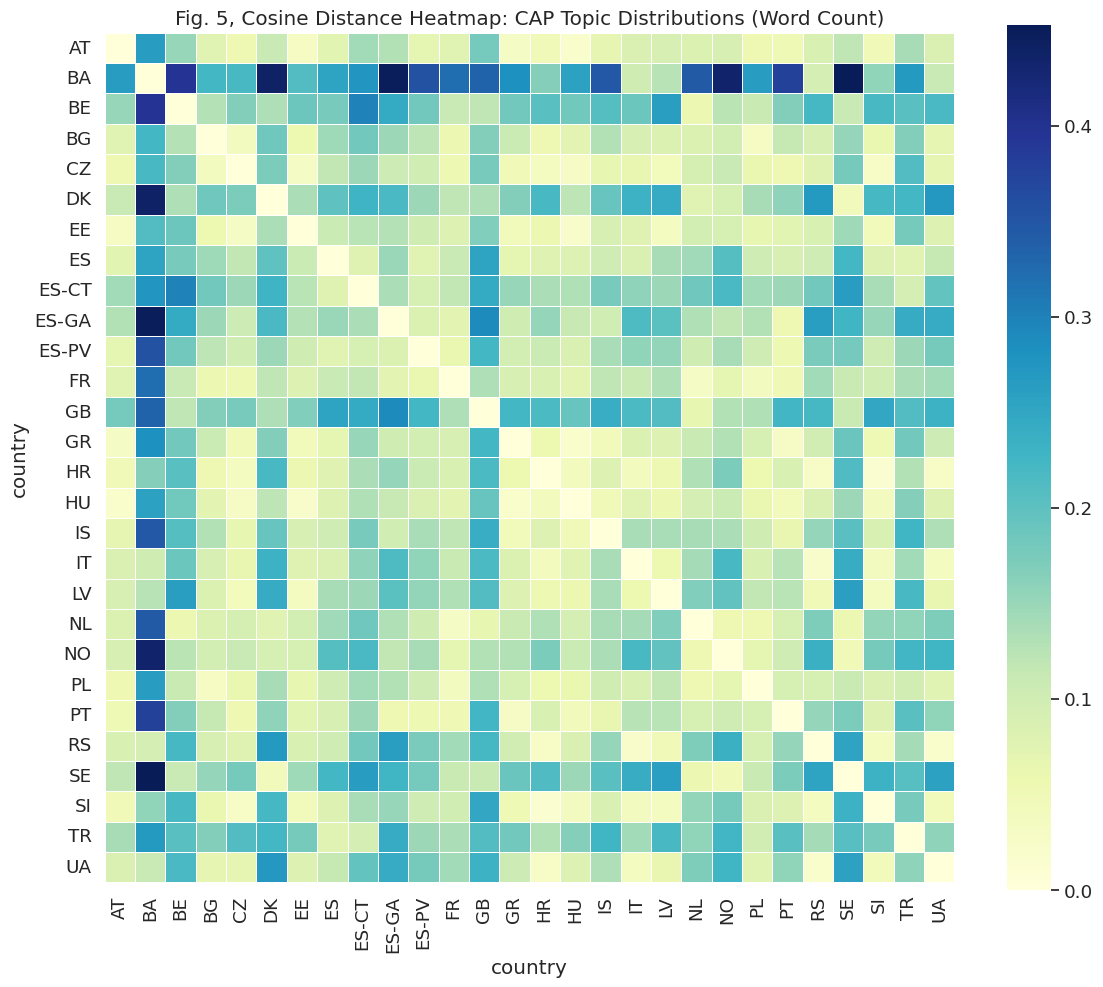

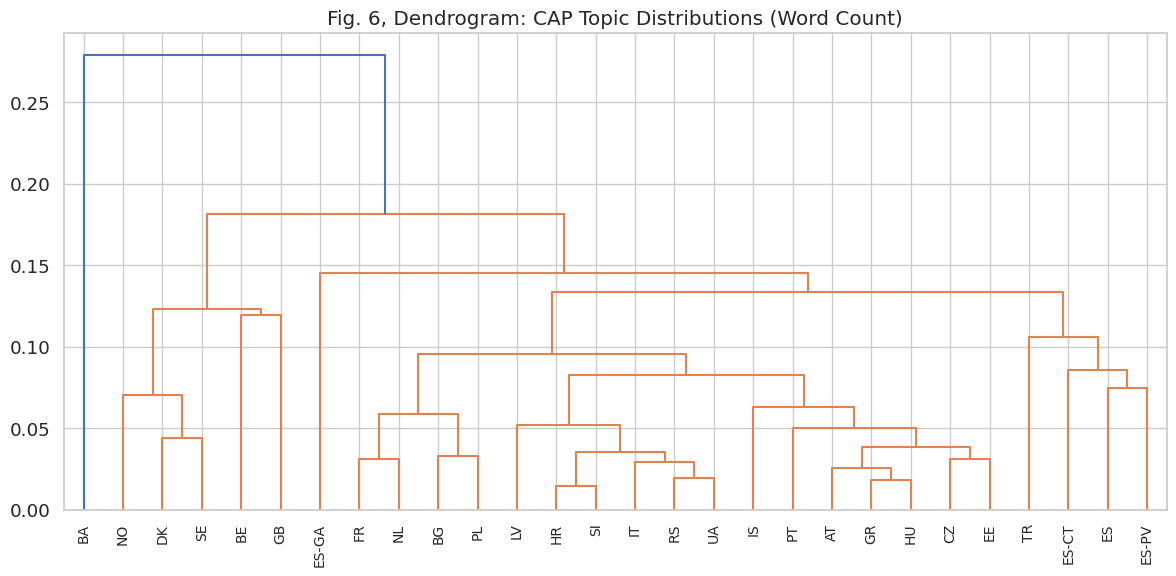

In [9]:
# ---- 1. Pivot data: rows = country, columns = CAP_category, values = total word count ----
country_cap_words = (
    filtered_all.groupby(["country", "CAP_category"], observed=True)["word_count"]
    .sum()
    .unstack(fill_value=0)
)

# ---- 1.1 Normalize to proportions ----
country_cap_words_norm = country_cap_words.div(country_cap_words.sum(axis=1), axis=0)

# ---- 2. Compute cosine distance ----
cosine_words_matrix = cosine_distances(country_cap_words_norm.values)

# ---- 2.1 Convert to DataFrame ----
cosine_words_df = pd.DataFrame(
    cosine_words_matrix,
    index=country_cap_words_norm.index,
    columns=country_cap_words_norm.index,
).round(5)

# ---- 2.2 Export to TSV ----
cosine_words_df.to_csv("cosine_distance_wordcounts.tsv", sep="\t")
print(cosine_words_df)

# ---- 3. Heatmap ----
plt.figure(figsize=(12, 10))
sns.heatmap(cosine_words_df, cmap="YlGnBu", linewidths=0.5, square=True)
plt.title("Fig. 5, Cosine Distance Heatmap: CAP Topic Distributions (Word Count)")
plt.tight_layout()
plt.show()

# ---- 4. Dendrogram ----
condensed_words = squareform(cosine_words_matrix, checks=False)
linked_words = linkage(condensed_words, method="average")
plt.figure(figsize=(12, 6))
dendrogram(linked_words, labels=country_cap_words_norm.index.tolist(), leaf_rotation=90)
plt.title("Fig. 6, Dendrogram: CAP Topic Distributions (Word Count)")
plt.tight_layout()
plt.show()


*Figure 5, the heatmap, reveals some interesting patterns in topic similarity across parliaments. In general, **Bosnia (BA)** and **Great Britain (GB)** stand out as more distinct from the majority of countries. Certain country pairs are particularly striking as outliers, such as **BA & SE**, **BA & DK** and **BA & ES-GA**, highlighting areas where parliamentary focus differs greatly.*

*On the other hand, a number of countries are closely aligned: **Estonia (EE) and Austria (AT)**, **Hungary (HU) and AT, Croatia (HR) and Serbia (RS)** and **HR & Ukraine (UA)** all exhibit high similarity in their topic distributions. Notably, **HR & RS** remain highly aligned even in this broader comparison, supporting the patterns observed in the pairwise analysis in **Section 4.1**.*

*Figure 6, the dendrogram, further illustrates these relationships. The tightest clusters are among **RS & UA (& HR), AT & HU (& GR), CZ & EE** and **DK & SE**. These clusters reflect parliaments that share very similar patterns on hor they allocate attention across CAP categories, while countries that branch off earlier represent distinctive approaches to parliamentary discourse.*

**4.3. Find the nearest neighbor (three most similar countries based on topic distributions)**

After visualizing the heatmap and dendrogram for **CAP topic distributions**, we can now take a **closer, country-specific look**. Similar to what we did for sentiment in **Section 3.3.**, we can use the **cosine distance matrix** to identify the **three countries whose topic distributions are most similar** to each country. 

In [10]:
# ---- 1. Mask the diagonal to ignore self-comparison ----
masked_words_df = cosine_words_df.mask(np.eye(len(cosine_words_df), dtype=bool))

# ---- 2. Find the 3 most similar countries for each country ----
nearest_neighbors_words = masked_words_df.apply(
    lambda row: row.nsmallest(3).index.tolist(), axis=1
)

# ---- 3. Display the results ----
for country, neighbors in nearest_neighbors_words.items():
    print(f"{country}: {', '.join(neighbors)}")


AT: HU, GR, EE
BA: RS, IT, UA
BE: NL, PL, FR
BG: PL, CZ, HR
CZ: SI, HU, EE
DK: SE, NL, NO
EE: HU, CZ, AT
ES: GR, AT, ES-PV
ES-CT: ES, ES-PV, TR
ES-GA: PT, FR, ES-PV
ES-PV: PT, FR, AT
FR: NL, PL, PT
GB: NL, SE, BE
GR: HU, PT, AT
HR: SI, UA, RS
HU: GR, AT, EE
IS: GR, HU, PT
IT: RS, UA, SI
LV: SI, EE, CZ
NL: FR, NO, PL
NO: SE, NL, FR
PL: BG, FR, NL
PT: GR, HU, AT
RS: UA, IT, HR
SE: DK, NO, NL
SI: HR, CZ, LV
TR: ES, ES-CT, PL
UA: RS, HR, IT


*The results show patterns of similarity across European parliaments in how they allocate attention to CAP topics. **Austria (AT)**, for instance, is most similar to **Hungary, Greece and Estonia** - two of which (**HU** and **EE**) were also Austria's nearest neighbors in **Section 3.3.** of tis tutorial, when we analyzed sentiment profiles.*

*Overall, we can identify some **regional clusters**, like **Bosnia (BA)** which stands out with neighbors **RS, UA** and **LV**, indicating different positioning compared to Western European parliaments. Northern and Western European countries also show close alignment: **Denmark (DK)** with **Sweden (SE), Netherlands (NL)** and **Austria (AT)**. Some smaller countries, such as **Iceland (IS)**, align with multiple Central and Southern European countries (**Greece, Hungary, Czech Republic**), reflecting common topic priorities despite their geographic distance.*

**5. Conclusion**

In this tutorial, we extended the analysis from **country-specific descriptive statistics** to **cross-parliament comparisons**. With the help of **cosine distance**, we were able to:
- Measure **how similar or different countries are** in the topics they discuss and the way they express sentiment in parliament.
- Find **groups of countries that behave similarly** (nearest neighbors and clusters).
-  Spot **outliers** - countries that stand out because they focus on different topics or express sentiment in a different way.

Overall, the combination of **numerical measures, heatmaps and dendrograms** provides a powerful toolkit for exploring **comparative parliamentary discourse**. 

In the next tutorial (**Tutorial 4**), we will shift our focus from static comparisons to **how sentiment and attention change over time**. We will explore weekly patterns in parliamentary debates, showing which topics become more positive or negative and how much attention different countries devote to key issues like 'Health'.
